In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# https://www.google.com/get/sunroof/data-explorer/place/ChIJ7cmZVwkRsYkRxTxC4m0-2L8/
data = pd.read_csv('../data/google_processed.csv')

In [3]:
# install size in kilowatts, 1000
# Google assumes each panel 250 W flush with the roof
# yields 2-3lbs of produce per sq.ft.
# Assume actual growing space 1 / 5 total space, 2 - 3 pounds per square foot per season
# Pounds of produce per season

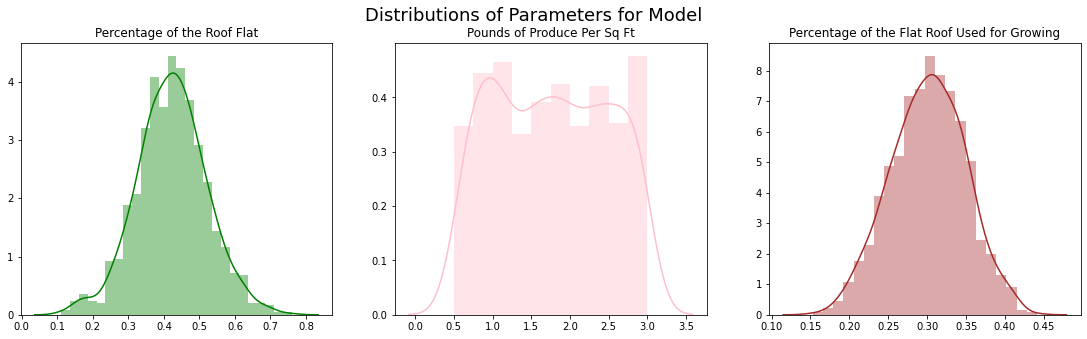

In [4]:
fig, axes = plt.subplots(1,3,figsize=(19,5))

est = np.random.normal(.42,.1,1000)
p = np.random.uniform(.5,3,1000)
x = np.random.normal(.3,.05,1000)

sns.distplot(est,ax=axes[0],color='green')
sns.distplot(p,ax=axes[1],color='pink')
sns.distplot(x,ax=axes[2],color='brown')
axes[0].set_title('Percentage of the Roof Flat')
axes[1].set_title('Pounds of Produce Per Sq Ft')
axes[2].set_title('Percentage of the Flat Roof Used for Growing')

plt.suptitle('Distributions of Parameters for Model',fontsize=18);

In [5]:
def get_produce(json_file):
    # Each row in dataset contains json-like data structure, converts
    sizes = json.loads(json_file)
    # Assumptions for parameters
    flat_fraction = np.random.normal(.42,.1)
    pct_roof_farmed = np.random.normal(.3,.05)
    produce_rate_per_sf = np.random.uniform(.5,3)
    # Initialize lists                                 
    flat_roof_size = []
    dist = []
    # Loop through each bin and the distribution of the capacity                                 
    for size in sizes:
        # Predicted rooftop solar capacity in KWs DC
        kw_install = size[0]
        # Number of roofs in this bin
        roofs = size[1]
        # Convert to watts, divide by 250 W panel, multiply by size of panel in sq ft, get fraction flat 
        n = kw_install * 1000 / 250 * flat_fraction * 17.6183686
        # Append to lists
        flat_roof_size.append(n)
        dist.append(roofs)
    # Convert to numpy for element-wise multiplication property
    flat_roof_size = np.array(flat_roof_size) 
    #dist = np.array(dist) 
    # Only considers roofs above 10,000 Square Feet
    size_above_10000 = flat_roof_size[flat_roof_size > 10000]
    #dist_above_10000 = dist[flat_roof_size > 10000]
    return (np.sum(flat_roof_size * dist * produce_rate_per_sf * pct_roof_farmed))

In [6]:
bootstraps = 1000
# Get the top 100 cities by the number of roofs viable for solar pv in numpy array
cities = data.sort_values('count_qualified',ascending=False).iloc[:100,:]['install_size_kw_buckets_json'].to_numpy()
seasonal_produce_totals = []

for _ in range(bootstraps):
    # Resample data
    resample_idx = np.random.randint(0,len(cities),size=(len(cities)))
    bootstrap_cities = cities[resample_idx]
    seasonal_produce_total = 0
    
    for city in bootstrap_cities:
        # Get produce total for each city
        seasonal_produce_total += get_produce(city)
    seasonal_produce_totals.append(seasonal_produce_total)

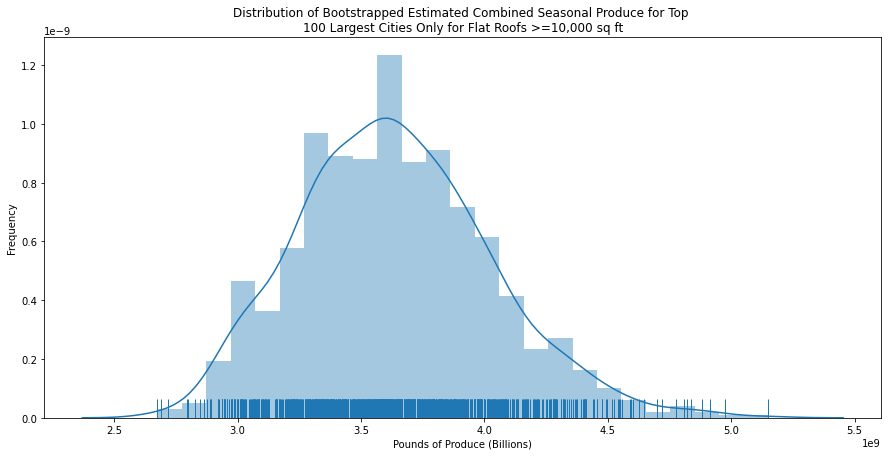

In [7]:
fig, ax = plt.subplots(figsize=(15,7))
sns.distplot(seasonal_produce_totals,rug=True,ax=ax)
ax.set_title('Distribution of Bootstrapped Estimated Combined Seasonal Produce for Top \n100 Largest Cities Only for Flat Roofs >=10,000 sq ft')
ax.set_xlabel('Pounds of Produce (Billions)')
ax.set_ylabel('Frequency');

In [8]:
bootstraps = 100
seasonal_produce_means = []
seasonal_produce_std = []

for city in cities:
    # Get produce total for each city
    seasonal_produce_total = []
    for _ in range(bootstraps):
        seasonal_produce_total.append(get_produce(city))
    seasonal_produce_means.append(np.mean(seasonal_produce_total))
    seasonal_produce_std.append(np.std(seasonal_produce_total))
seasonal_produce_totals = np.sum(seasonal_produce_means)
seasonal_produce_std = np.array(seasonal_produce_std)
seasonal_produce_totals_std = np.sqrt(np.sum(seasonal_produce_std**2))

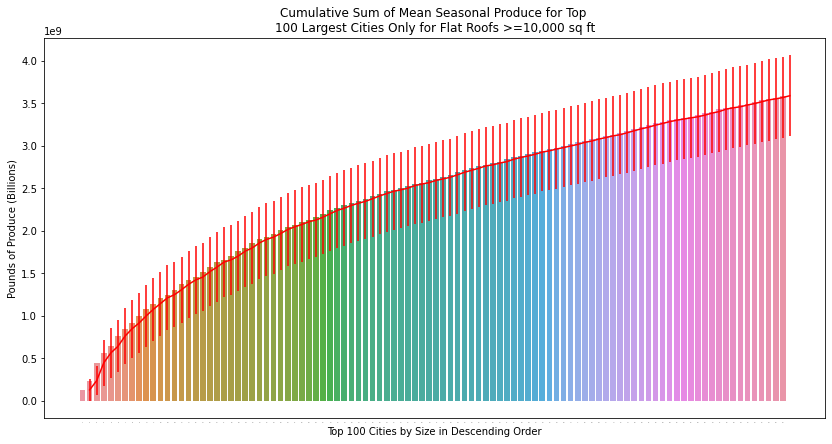

In [9]:
fig, ax = plt.subplots(figsize=(14,7))
sns.barplot(x=np.arange(1,101),y=np.cumsum(seasonal_produce_means),ax=ax)
ax.tick_params(axis='x', which='both', length=0,labelsize=0)
ax.set_title('Cumulative Sum of Mean Seasonal Produce for Top \n100 Largest Cities Only for Flat Roofs >=10,000 sq ft')
ax.set_xlabel('Top 100 Cities by Size in Descending Order')
ax.set_ylabel('Pounds of Produce (Billions)')
plt.errorbar(np.arange(1,101), np.cumsum(seasonal_produce_means),yerr=np.sqrt(np.cumsum(seasonal_produce_std**2))*2,color='red');

In [10]:
# Paths Forward
# algo to predict if roof flat from pictures of roof over time 
# mean and confidence intervals for each city
# single city, looking at roofs less than 10,000
# machine learning model to predict flat roof size for 28,000 cities